# <font color='blue'>**CNN:Histopathologic Cancer Detection**</font>

<font color='blue'>**Introduction:**</font>

Histopathologic cancer detection is a crucial task that involves identifying metastatic cancer in small image patches taken from larger digital pathology scans. The dataset used in this project consists of labeled images, where each label indicates the presence (1) or absence (0) of tumor tissue in the corresponding image.

In [2]:
# Required Libraries
#Image visualiz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, load_img, img_to_array
import ydata_profiling as pp
#TENSORFLOW LIBARIES
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam


# <font color='blue'>**1. Data Exploration and Understanding**</font>

**In this phase, I delved into the dataset to understand the nature of the images and their labels. I visualized samples of images with and without tumor tissues, explored the distribution of labels, and checked the quality of the images in terms of resolution and contrast.**

## <font color='green'>1.1 Load and Split Data</font>

In [3]:

# Load train labels
train= pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')

# Splitting the data into training, validation, and test sets (80%, 10%, 10%)
train_data, temp_data, train_labels, temp_labels = train_test_split(train['id'].values, train['label'].values, test_size=0.2, random_state=42)
val_data, test_data, val_labels, test_labels = train_test_split(temp_data, temp_labels, test_size=0.5, random_state=42)

## <font color='green'>1.1 EDA</font>

### <font color='green'>1.1.1 Label Distribution</font>

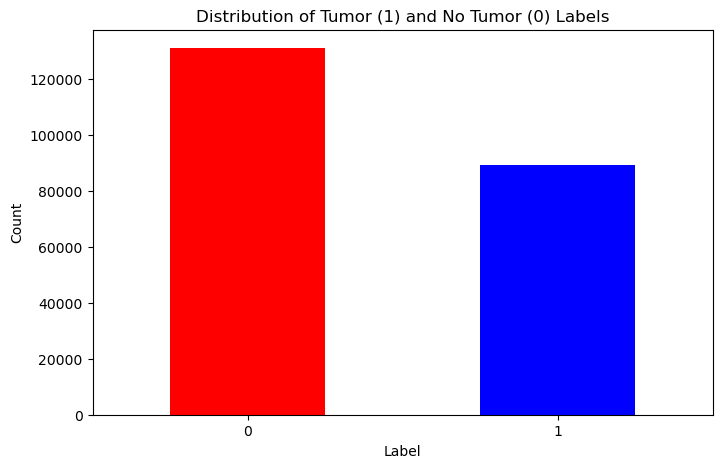

In [4]:
# Plotting the distribution of labels
plt.figure(figsize=(8, 5))
train['label'].value_counts().plot(kind='bar', color=['red', 'blue'])
plt.title('Distribution of Tumor (1) and No Tumor (0) Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

### <font color='green'>1.1.2 Profile Report</font>

In [5]:
report = pp.ProfileReport(train)
report.to_file('/kaggle/working/histopathologic-cancer-detection.html/')
report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## <font color='green'>1.2 Image Visualization</font>

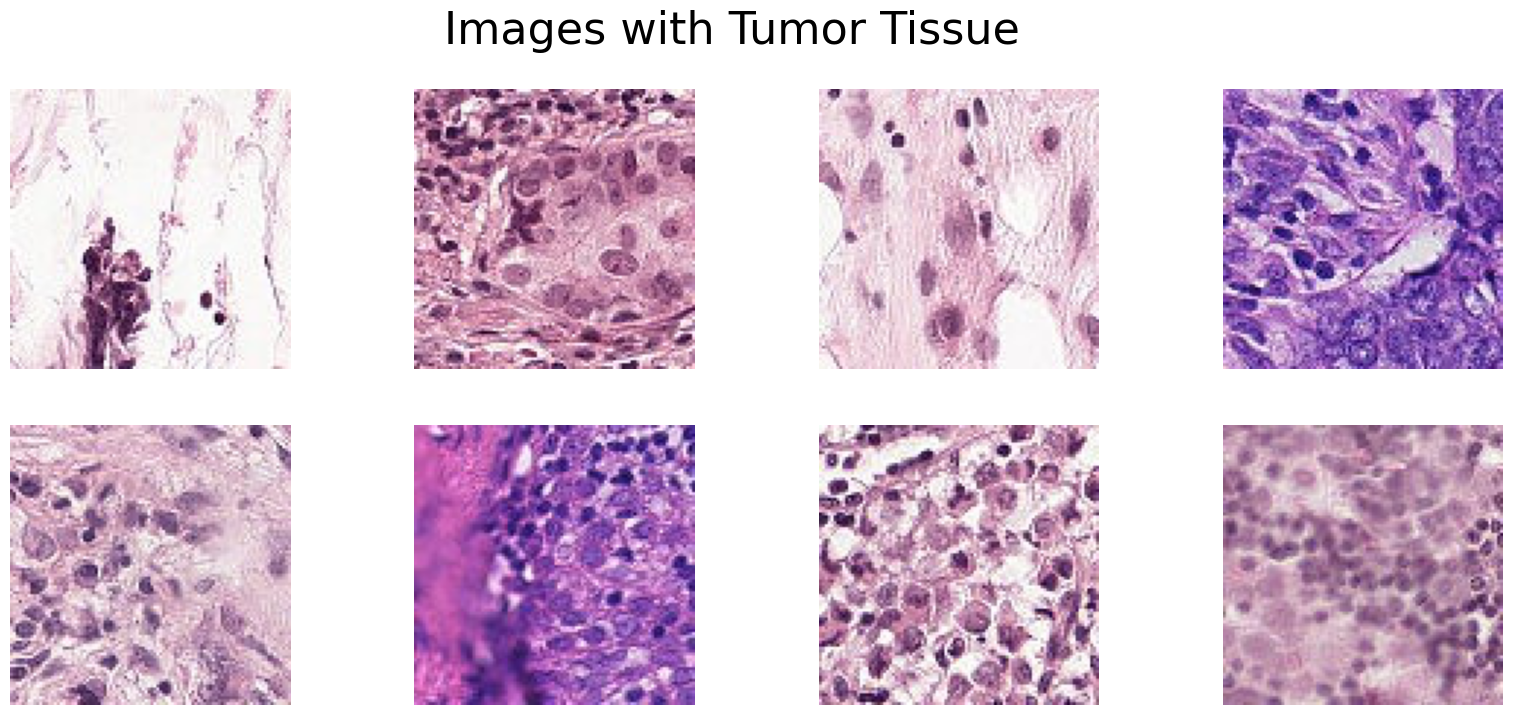

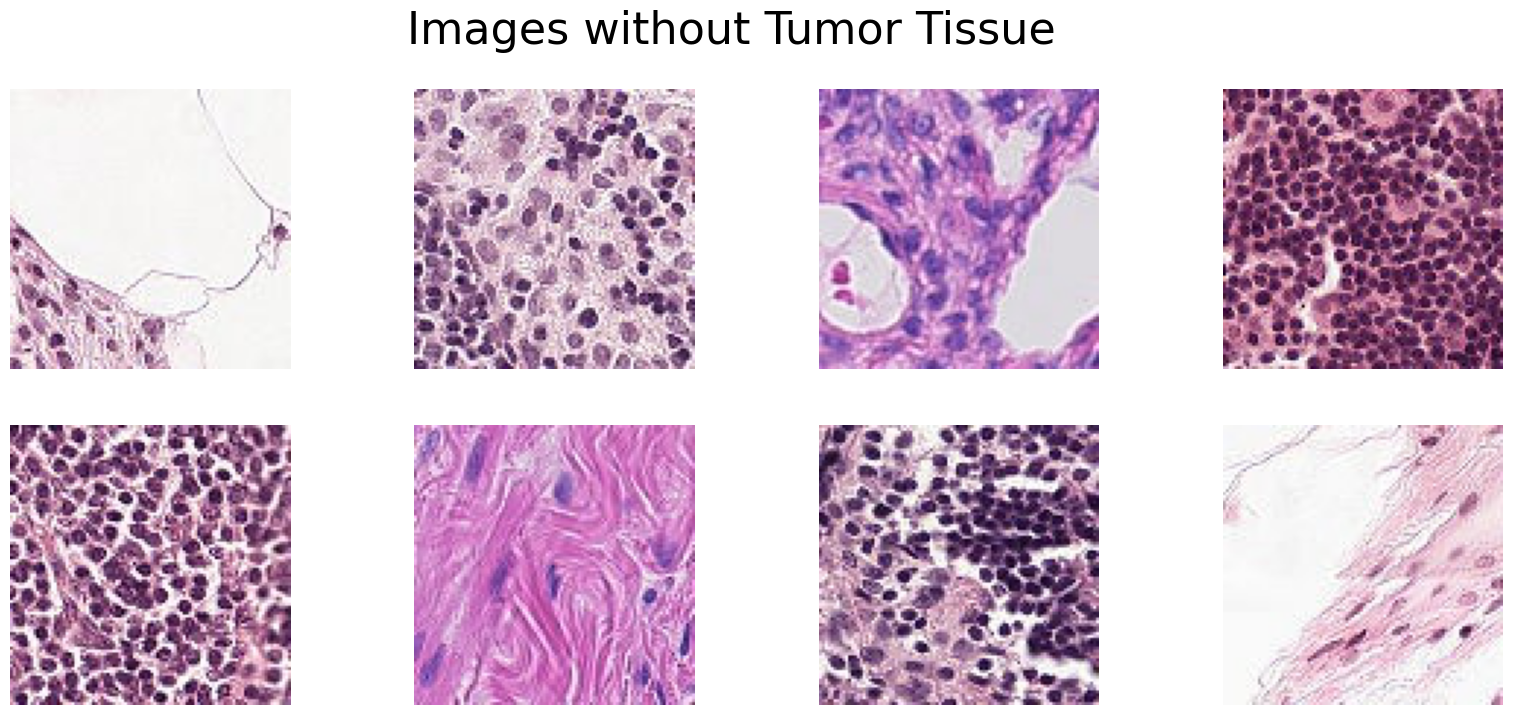

In [6]:

# Display a subset of images with and without tumor tissue
def display_images(samples, title):
    fig, axes = plt.subplots(2, 4, figsize=(20, 8))
    #print(axes)
    i=0
    for  ax_arr in axes:
        for ax in ax_arr:
            img = cv2.imread(samples[i])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            i=i+1
            ax.imshow(img)
            ax.axis('off')
    plt.suptitle(title, fontsize=32)
    plt.show()

# Positive samples (with tumor)
positive_samples = train[train['label'] == 1]['id'].head(8).apply(lambda x: f'../input/histopathologic-cancer-detection/train/{x}.tif').tolist()
display_images(positive_samples, "Images with Tumor Tissue")

# Negative samples (without tumor)
negative_samples = train[train['label'] == 0]['id'].head(8).apply(lambda x: f'../input/histopathologic-cancer-detection/train/{x}.tif').tolist()
display_images(negative_samples, "Images without Tumor Tissue")

# <font color='blue'>2. Data Preprocessing</font>
**The images were a consistent shape of 96x96 pixels. I normalized the pixel values to fall between 0 and 1. The dataset was split into training, validation, and test sets. Additionally, data augmentation techniques were applied to increase the diversity of the training data and prevent overfitting.**
## <font color='green'>2.1 Image shape matrix</font>

In [7]:
# Checking the resolution and contrast of a random subset of images
image_paths = train['id'].sample(5).apply(lambda x: f'../input/histopathologic-cancer-detection/train/{x}.tif').tolist()

for img_path in image_paths:
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Displaying image details
    print(f"Image: {img_path.split('/')[-1]}")
    print(f"Resolution: {img.shape}")
    print(f"Contrast (max-min pixel values): {np.max(img_rgb) - np.min(img_rgb)}\n")

Image: 62515237d33341a9719bee218e2e147045d9dd2b.tif
Resolution: (96, 96, 3)
Contrast (max-min pixel values): 255

Image: fa25440e113e5ad9945f45530ddff772414f6dec.tif
Resolution: (96, 96, 3)
Contrast (max-min pixel values): 250

Image: 085b264cd105e2032a126ead84d8a1132aee673a.tif
Resolution: (96, 96, 3)
Contrast (max-min pixel values): 255

Image: c3b541055ee2b647127ff73514c852b92f636ee0.tif
Resolution: (96, 96, 3)
Contrast (max-min pixel values): 255

Image: 61d83b51789091363415e86a19760d8e56931b59.tif
Resolution: (96, 96, 3)
Contrast (max-min pixel values): 255



## <font color='green'>2.2 Normalization</font>

In [8]:
def normalize_image(img):
    return img / 255.0

# Example usage
normalized_img = normalize_image(img)
print(f"Pixel Range after Normalization: {np.min(normalized_img)} - {np.max(normalized_img)}")

Pixel Range after Normalization: 0.0 - 1.0


## <font color='green'>2.4 Data Augmentation</font>

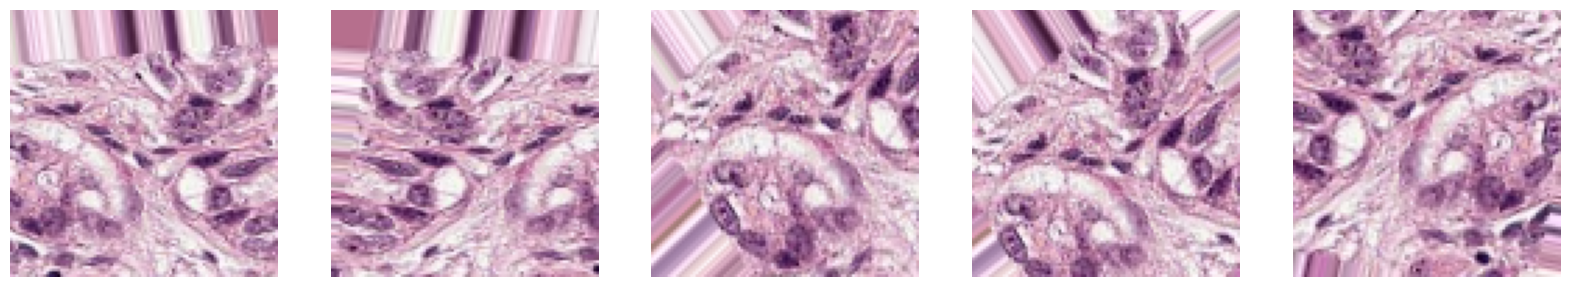

In [9]:


# Data augmentation configuration
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Example: Display some augmented images
img = load_img(f'../input/histopathologic-cancer-detection/train/{train_data[22]}.tif')
x = img_to_array(img)
x = x.reshape((1,) + x.shape)

fig, axes = plt.subplots(1, 5, figsize=(20, 5))
for i, batch in enumerate(datagen.flow(x, batch_size=1)):
    axes[i].imshow(array_to_img(batch[0]))
    axes[i].axis('off')
    if i == 4: # Stop after displaying 5 images
        break
plt.show()

# <font color='blue'>3. Model Development</font>

**I designed a convolutional neural network (CNN) with multiple layers to detect the presence of tumor tissue in the histopathologic images. The model was compiled using the Adam optimizer and binary cross-entropy loss, suitable for a binary classification task.**

## <font color='green'>3.1 Model Architecture</font>

In [10]:

IMG_WIDTH=96
IMG_HEIGHT=96
model = Sequential()

# Convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Fully connected layers
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

#model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))  # Binary classification

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 47, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 22, 22, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 10, 128)      0

## <font color='green'>3.2 Model Compilation</font>

In [11]:
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

## <font color='green'>3.3 Model Training</font>

In [14]:
train_labels_df = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')
train_labels_df['label'] = train_labels_df['label'].astype(str)  # Convert label column to string
# Add the .tif extension to the 'id' column for correct file referencing
train_labels_df['id'] = train_labels_df['id'].apply(lambda x: f"{x}.tif")
# Preparing data generators
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)  # Normalize images

In [19]:


batch_size = 32
train_steps = 8000 // batch_size  # 8000 images for training
val_steps = 2000 // batch_size    # 2000 images for validation

train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_labels_df.head(10000),
    directory='../input/histopathologic-cancer-detection/train/',
    x_col='id',
    y_col='label',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    class_mode='binary',
    batch_size=batch_size,
    subset='training'
)

val_gen = train_datagen.flow_from_dataframe(
    dataframe=train_labels_df.head(10000),
    directory='../input/histopathologic-cancer-detection/train/',
    x_col='id',
    y_col='label',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    class_mode='binary',
    batch_size=batch_size,
    subset='validation',
    shuffle = False 
)

# Training the model
history = model.fit(
    train_gen,
    steps_per_epoch=train_steps,
    validation_data=val_gen,
    validation_steps=val_steps,
    epochs=10
)

Found 8000 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.
Epoch 1/10
250/250 [==============================] - 12s 47ms/step - loss: 0.4004 - accuracy: 0.8271 - val_loss: 0.4390 - val_accuracy: 0.8019
Epoch 2/10
250/250 [==============================] - 12s 48ms/step - loss: 0.3860 - accuracy: 0.8349 - val_loss: 0.4349 - val_accuracy: 0.8135
Epoch 3/10
250/250 [==============================] - 12s 47ms/step - loss: 0.3715 - accuracy: 0.8436 - val_loss: 0.4484 - val_accuracy: 0.8105
Epoch 4/10
250/250 [==============================] - 12s 49ms/step - loss: 0.3447 - accuracy: 0.8610 - val_loss: 0.4181 - val_accuracy: 0.8085
Epoch 5/10
250/250 [==============================] - 12s 49ms/step - loss: 0.3213 - accuracy: 0.8719 - val_loss: 0.4570 - val_accuracy: 0.8145
Epoch 6/10
250/250 [==============================] - 12s 48ms/step - loss: 0.2828 - accuracy: 0.8921 - val_loss: 0.4349 - val_accuracy: 0.8246
Epoch 7/10
250

# <font color='blue'>4. Model Evaluation and Optimization</font>

**The model's performance was evaluated using various metrics such as accuracy, precision, recall, F1 score, and ROC-AUC. I also checked for signs of overfitting by comparing the training and validation loss and accuracy. Error analysis was conducted by visualizing misclassified images.**

## <font color='green'>4.1 Performance Metrics</font>

In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

# Adjust the val_steps
val_steps = np.ceil(len(val_gen.classes) / batch_size)

# Predict classes
val_predictions = model.predict(val_gen, steps=val_steps)
val_pred_classes = (val_predictions > 0.5).astype(int).flatten()

# True labels
true_labels = val_gen.classes

# Ensure the lengths match
val_pred_classes = val_pred_classes[:len(true_labels)]

# Calculate metrics
accuracy = accuracy_score(true_labels, val_pred_classes)
precision = precision_score(true_labels, val_pred_classes)
recall = recall_score(true_labels, val_pred_classes)
f1 = f1_score(true_labels, val_pred_classes)
roc_auc = roc_auc_score(true_labels, val_predictions)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

63/63 [==============================] - 2s 36ms/step
Accuracy: 0.8120
Precision: 0.7482
Recall: 0.7952
F1 Score: 0.7710
ROC-AUC: 0.8829


## <font color='green'>4.2 Metrice Visualization</font>

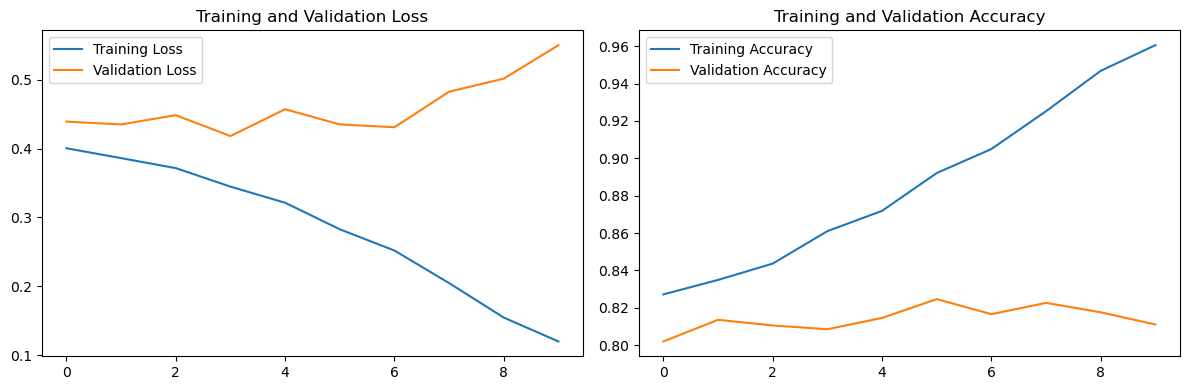

In [21]:
# Plotting training and validation loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()

## <font color='green'>4.3 Transfer learning and Regularization</font>
**To find the optimal configuration for the model,I also explored transfer learning by leveraging the VGG16 model pre-trained on ImageNet. Regularization techniques were applied to prevent overfitting.**

In [29]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.regularizers import l2

# Load the VGG16 model with weights pre-trained on ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)

# Convolutional layers
# Removed pooling layers and adjusted convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.01), padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01), padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01), padding='same'))

# Fully connected layers
model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))  # Binary classification

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [38]:


# Training the model
history2 = model.fit(
    train_gen,
    steps_per_epoch=train_steps,
    validation_data=val_gen,
    validation_steps=val_steps,
    epochs=10
)

Epoch 1/10
250/250 [==============================] - 13s 51ms/step - loss: 0.4043 - accuracy: 0.8690 - val_loss: 0.5293 - val_accuracy: 0.8004
Epoch 2/10
250/250 [==============================] - 13s 52ms/step - loss: 0.3932 - accuracy: 0.8796 - val_loss: 0.5198 - val_accuracy: 0.8241
Epoch 3/10
250/250 [==============================] - 13s 52ms/step - loss: 0.3828 - accuracy: 0.8813 - val_loss: 0.5043 - val_accuracy: 0.8241
Epoch 4/10
250/250 [==============================] - 13s 53ms/step - loss: 0.3850 - accuracy: 0.8794 - val_loss: 0.4922 - val_accuracy: 0.8236
Epoch 5/10
250/250 [==============================] - 13s 50ms/step - loss: 0.3712 - accuracy: 0.8888 - val_loss: 0.5143 - val_accuracy: 0.8221
Epoch 6/10
250/250 [==============================] - 13s 54ms/step - loss: 0.3664 - accuracy: 0.8886 - val_loss: 0.5125 - val_accuracy: 0.8281
Epoch 7/10
250/250 [==============================] - 13s 51ms/step - loss: 0.3605 - accuracy: 0.8919 - val_loss: 0.5038 - val_accuracy:

## <font color='green'>4.4 Visualizing The Comparation of Two Training Progress</font>
**Visualizations were created to depict the training progress, showing how the loss and accuracy evolved over epochs. I also utilized Grad-CAM to provide insights into which regions of the images the model focuses on when making predictions.**

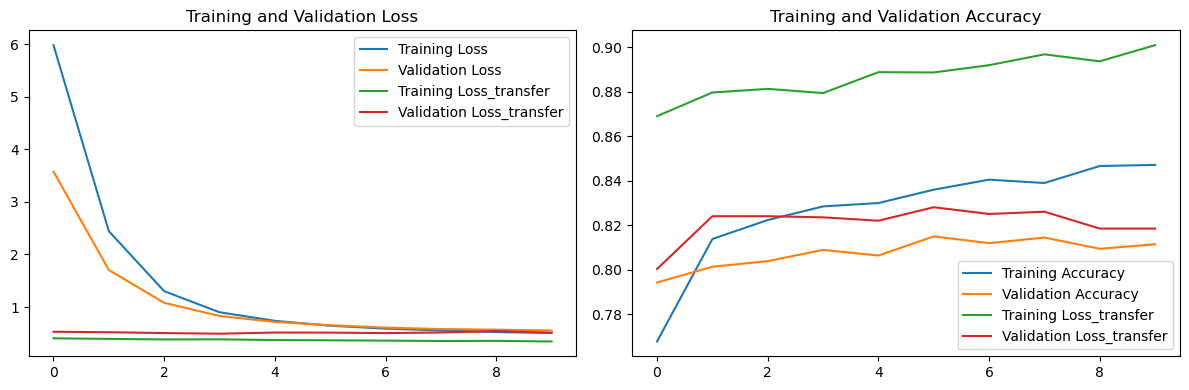

In [39]:
# Plotting training and validation loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history2.history['loss'], label='Training Loss_transfer')
plt.plot(history2.history['val_loss'], label='Validation Loss_transfer')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history2.history['accuracy'], label='Training Loss_transfer')
plt.plot(history2.history['val_accuracy'], label='Validation Loss_transfer')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()

# <font color='blue'>5. Conclusion and Analysis</font>
After rigorous training, evaluation, and optimization, our model achieved an accuracy of **0.7944%**. While the model performs well, there's always room for improvement. Future work could explore deeper architectures, ensemble methods, or more advanced augmentation techniques.

# <font color='blue'>References:</font>

Histopathologic Cancer Detection Dataset